In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

from scipy import stats
from math import sqrt



### Loading Dataset

In [2]:
df = pd.read_csv('nyc-rolling-sales.csv')
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [3]:
#Dropping column as it is empty
del df['EASE-MENT']
#Dropping as it looks like iterator
del df['Unnamed: 0']

del df['SALE DATE']

In [4]:
#Checking for dublicated entries
sum(df.duplicated(df.columns))

1358

In [5]:
#Delete the dublicates and check that it worked
df = df.drop_duplicates(df.columns, keep='last')
sum(df.duplicated(df.columns))

0

### Data Inspection & Visualization

In [6]:
df.shape

(83190, 19)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83190 entries, 0 to 84547
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         83190 non-null  int64 
 1   NEIGHBORHOOD                    83190 non-null  object
 2   BUILDING CLASS CATEGORY         83190 non-null  object
 3   TAX CLASS AT PRESENT            83190 non-null  object
 4   BLOCK                           83190 non-null  int64 
 5   LOT                             83190 non-null  int64 
 6   BUILDING CLASS AT PRESENT       83190 non-null  object
 7   ADDRESS                         83190 non-null  object
 8   APARTMENT NUMBER                83190 non-null  object
 9   ZIP CODE                        83190 non-null  int64 
 10  RESIDENTIAL UNITS               83190 non-null  int64 
 11  COMMERCIAL UNITS                83190 non-null  int64 
 12  TOTAL UNITS                     83190 non-null

In [8]:
#Convert the columns to appropriate datatype

df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['BOROUGH'] = df['BOROUGH'].astype('category')

In [9]:
#Checking missing values

df.columns[df.isnull().any()]

Index(['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE'], dtype='object')

In [10]:
miss = df.isnull().sum()/len(df)
miss = miss[miss>0]
miss.sort_values(inplace=True)
miss

SALE PRICE           0.167196
LAND SQUARE FEET     0.312213
GROSS SQUARE FEET    0.327888
dtype: float64

In [11]:
miss = miss.to_frame()
miss.columns=['count']
miss.index.names=['Name']
miss['Name']=miss.index
miss

,count,Name
Name,,
SALE PRICE,0.167196,SALE PRICE
LAND SQUARE FEET,0.312213,LAND SQUARE FEET
GROSS SQUARE FEET,0.327888,GROSS SQUARE FEET


<module 'seaborn' from 'd:\\Anaconda\\lib\\site-packages\\seaborn\\__init__.py'>

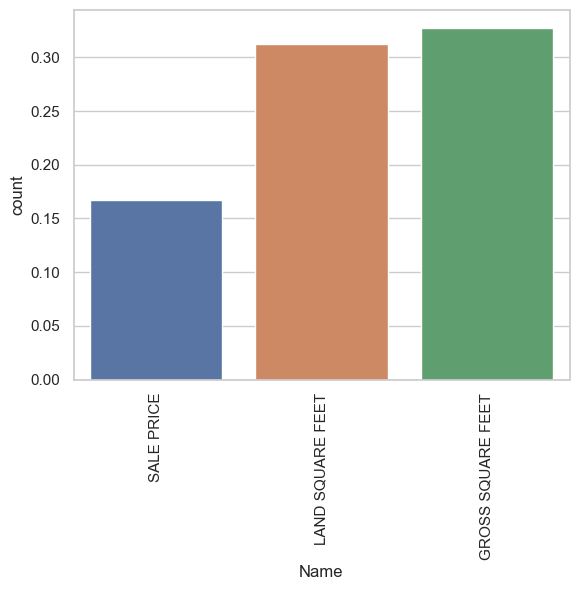

In [12]:
#Plot the missing values
sns.set(style='whitegrid', color_codes=True)
sns.barplot(x='Name', y='count', data=miss)
plt.xticks(rotation=90)
sns

In [13]:
#For now let's fill these up with mean values
df['LAMD SQIARE FEET']=df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['GROSS SQUARE FEET']=df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean())

In [14]:
#Splitting dataset
test=df[df['SALE PRICE'].isna()]
data=df[~df['SALE PRICE'].isna()]

In [15]:
test = test.drop(columns='SALE PRICE')

In [16]:
print(test.shape)
test.head(10)

(13909, 19)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,LAMD SQIARE FEET
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,234 EAST 4TH STREET,,10009,28,3,31,4616.0,18690.000000,1900,2,C7,4616.00000
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,197 EAST 3RD STREET,,10009,16,1,17,2212.0,7803.000000,1900,2,C7,2212.00000
5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,405,16,C4,516 EAST 12TH STREET,,10009,20,0,20,2581.0,9730.000000,1900,2,C4,2581.00000
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,18,C7,520 EAST 14TH STREET,,10009,44,2,46,5163.0,21007.000000,1900,2,C7,5163.00000
8,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,379,34,D5,141 AVENUE D,,10009,15,0,15,1534.0,9198.000000,1920,2,D5,1534.00000
10,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,394,44,D7,181 AVENUE C,,10009,30,4,34,4295.0,21328.000000,1910,2,D7,4295.00000
20,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2C,374,8,C6,"702 EAST 5TH STREET, 5E",,10009,0,0,0,NaN,3891.878472,1900,2,C6,3858.41804
30,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,379,15,C6,"414 EAST 10TH STREET, 1C",,10009,0,0,0,NaN,3891.878472,1930,2,C6,3858.41804
36,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,391,14,C6,"616 EAST 9TH STREET, 4W",,10009,0,0,0,NaN,3891.878472,1910,2,C6,3858.41804
48,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,396,20,C6,"626 EAST 14TH STREET, 5",,10009,0,0,0,NaN,3891.878472,1920,2,C6,3858.41804


<Axes: >

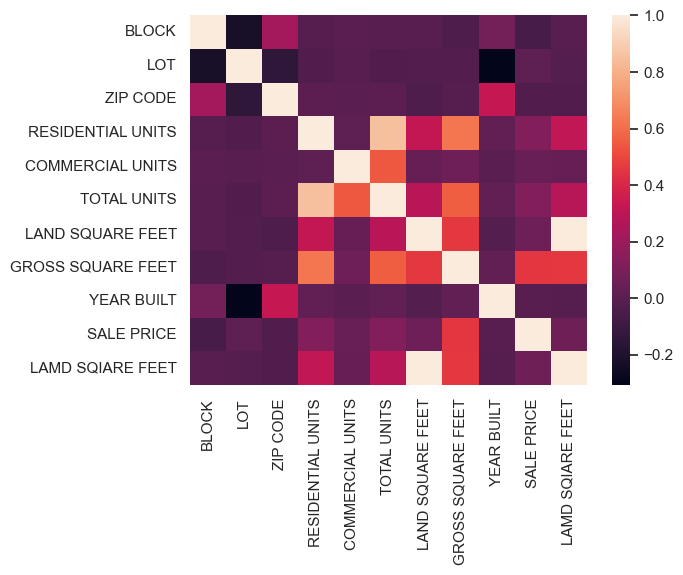

In [17]:
#Correlation between the features
corr = data.corr()
sns.heatmap(corr)

In [18]:
#Numeric Corellation
corr['SALE PRICE'].sort_values(ascending=False)

SALE PRICE           1.000000
GROSS SQUARE FEET    0.449913
TOTAL UNITS          0.126654
RESIDENTIAL UNITS    0.122566
LAND SQUARE FEET     0.061270
LAMD SQIARE FEET     0.060143
COMMERCIAL UNITS     0.044535
LOT                  0.012266
YEAR BUILT          -0.003779
ZIP CODE            -0.034110
BLOCK               -0.061357
Name: SALE PRICE, dtype: float64

In [19]:
numeric_data = data.select_dtypes(include=[np.number])
numeric_data.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,LAMD SQIARE FEET
count,69281.000000,69281.000000,69281.000000,69281.000000,69281.000000,69281.000000,4.813000e+04,6.928100e+04,69281.000000,6.928100e+04,6.928100e+04
mean,4200.305437,374.983473,10739.919458,1.870859,0.164244,2.055109,3.548421e+03,3.640300e+03,1800.113451,1.286521e+06,3.643061e+03
std,3434.828427,656.820333,1265.389144,14.317577,9.018311,17.026435,3.985828e+04,2.427118e+04,519.752668,1.145690e+07,3.322172e+04
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,1349.000000,21.000000,10306.000000,0.000000,0.000000,0.000000,1.425000e+03,1.268000e+03,1920.000000,2.350000e+05,1.900000e+03
50%,3377.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,2.150000e+03,2.400000e+03,1938.000000,5.350000e+05,2.970000e+03
75%,6192.000000,879.000000,11249.000000,2.000000,0.000000,2.000000,3.100000e+03,3.891878e+03,1965.000000,9.500000e+05,3.858418e+03
max,16319.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09,4.252327e+06


### Sale Price

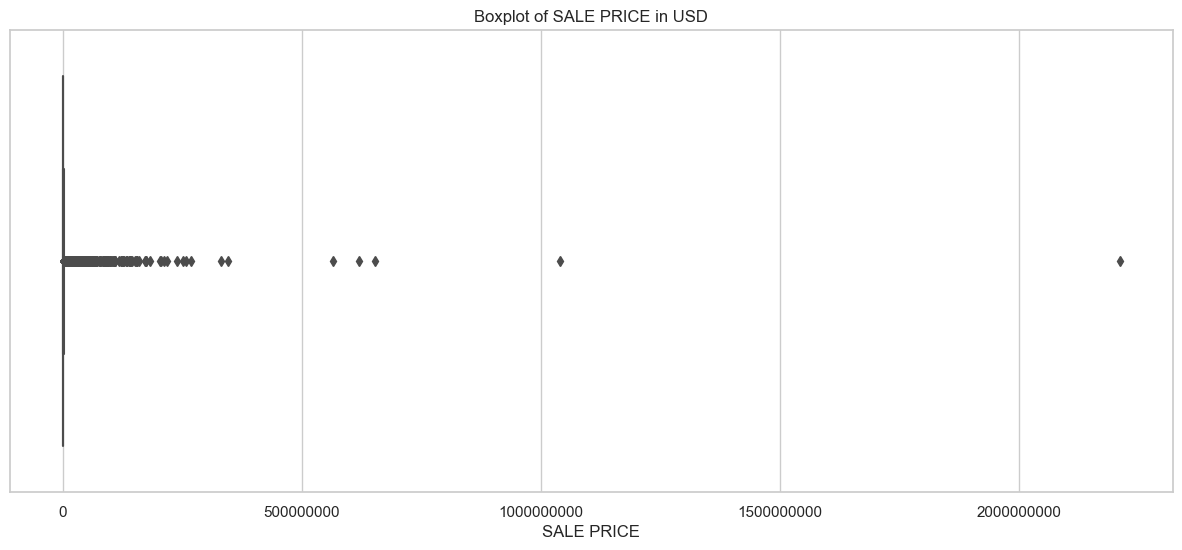

In [20]:
plt.figure(figsize=(15,6))

sns.boxplot(x='SALE PRICE', data=data)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

<Axes: xlabel='SALE PRICE', ylabel='Density'>

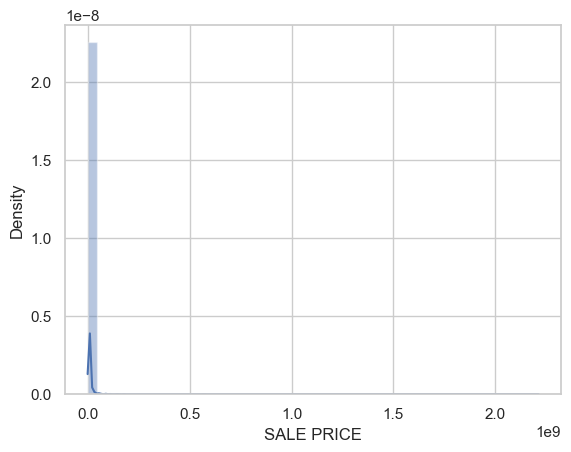

In [21]:
sns.distplot(data['SALE PRICE'])

In [22]:
#Remove observations that fall outside those caps
data = data[(data['SALE PRICE'] > 100000) & (data['SALE PRICE'] < 5000000)]

<Axes: xlabel='SALE PRICE', ylabel='Density'>

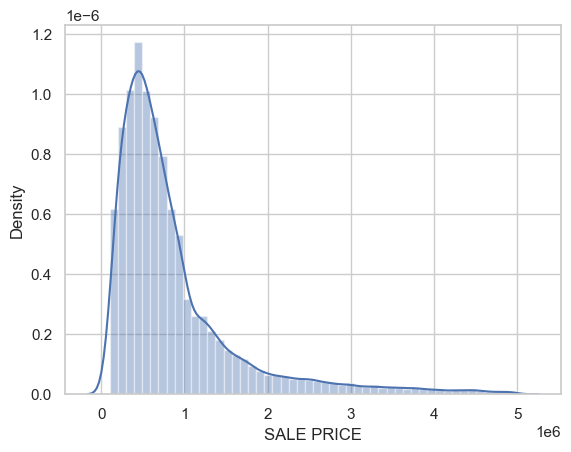

In [23]:
#Checking again after the removing
sns.distplot(data['SALE PRICE'])

In [24]:
#Skewness of SALE PRICE
data['SALE PRICE'].skew()

2.3437455096169386

#### SALE PRICE is highly right skewed. So, I will log transform it so that it give better results.

0.19896303705046872


<Axes: xlabel='SALE PRICE', ylabel='Density'>

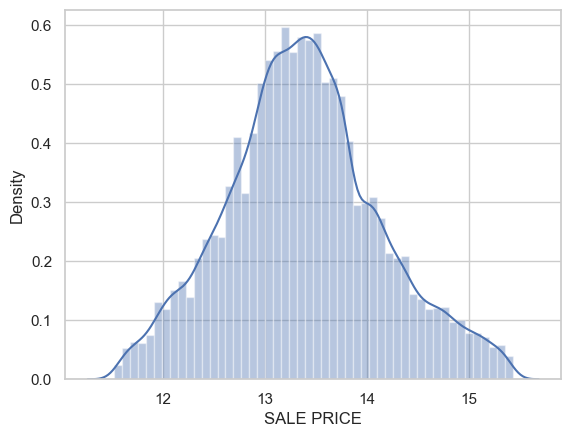

In [25]:
sales=np.log(data['SALE PRICE'])
print(sales.skew())
sns.distplot(sales)

### Now I can see the symmetry and thus it is normalised.

## Square Feet

<Axes: xlabel='GROSS SQUARE FEET'>

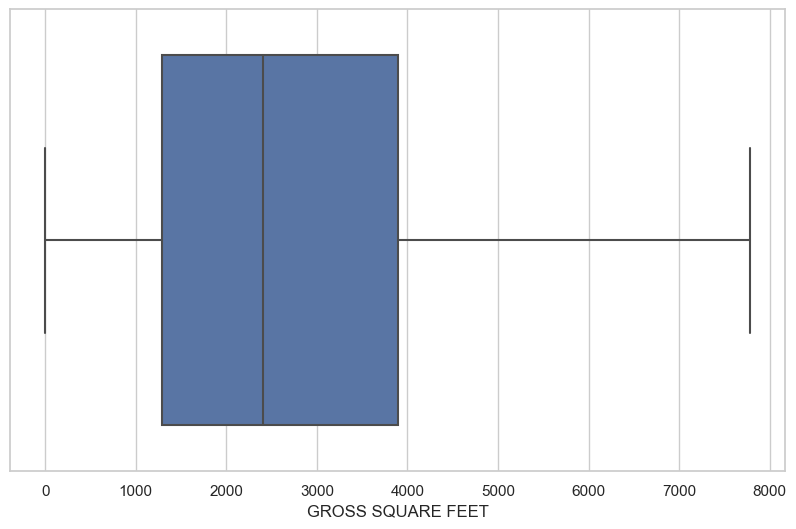

In [26]:
plt.figure(figsize=(10,6))
sns.boxplot(x='GROSS SQUARE FEET', data=data, showfliers=False)

<Axes: xlabel='LAND SQUARE FEET'>

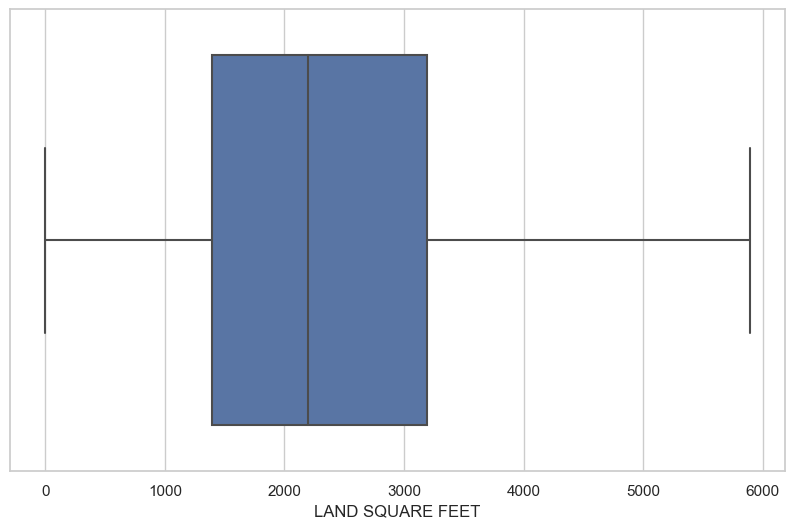

In [27]:
plt.figure(figsize=(10,6))
sns.boxplot(x='LAND SQUARE FEET', data=data, showfliers=False)

In [28]:
data = data[data['GROSS SQUARE FEET'] < 10000]
data = data[data['LAND SQUARE FEET'] < 10000]

<Axes: xlabel='GROSS SQUARE FEET', ylabel='SALE PRICE'>

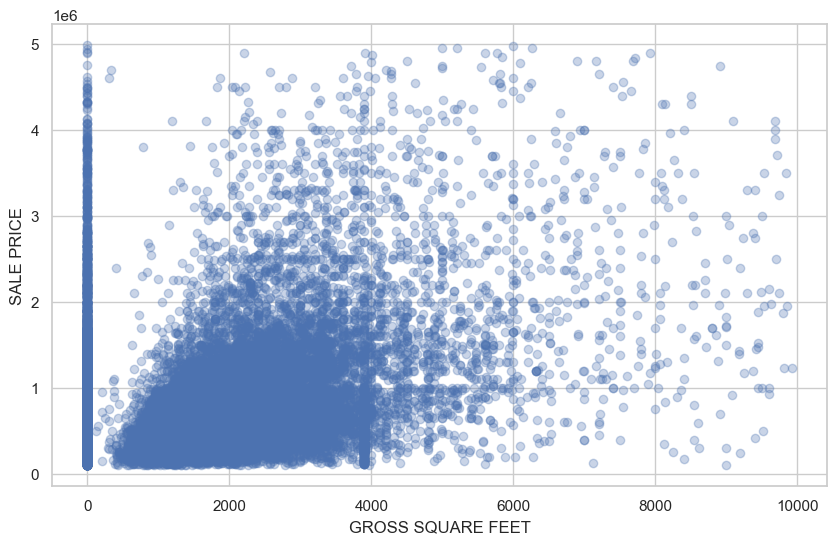

In [29]:
plt.figure(figsize=(10,6))
sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=data, fit_reg=False, scatter_kws={'alpha':0.3})

<Axes: xlabel='LAND SQUARE FEET', ylabel='SALE PRICE'>

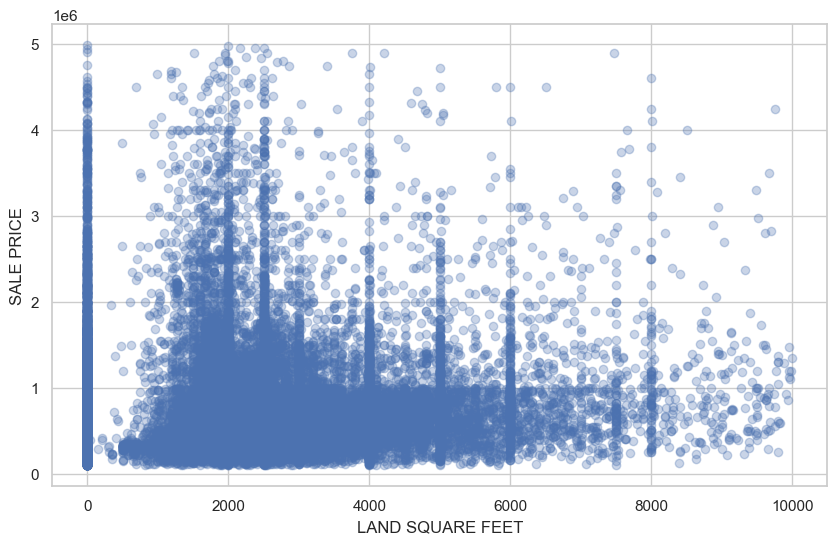

In [30]:
plt.figure(figsize=(10,6))
sns.regplot(x='LAND SQUARE FEET', y='SALE PRICE', data=data, fit_reg=False, scatter_kws={'alpha':0.3})

### Total Units, Commercial Units, Residential Units

In [31]:
data[['TOTAL UNITS', 'SALE PRICE']].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

,TOTAL UNITS,SALE PRICE
1,1,16628
2,2,9473
0,0,3969
3,3,2720
4,4,695
6,6,360
5,5,170
8,8,133
7,7,70
9,9,56


#### Removing rows with TOTAL UNITS == 0 and one outlier with 2261 units



In [32]:
data = data[(data['TOTAL UNITS']>0) & (data['TOTAL UNITS'] != 2261)]

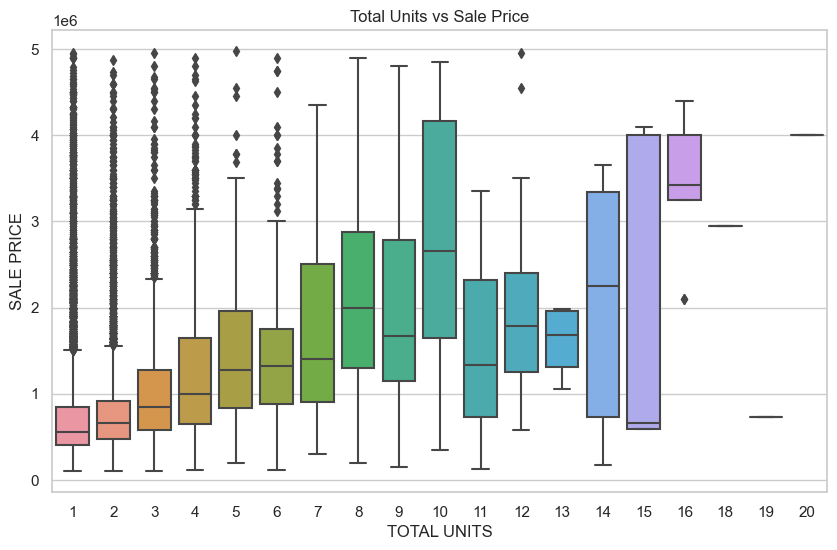

In [33]:
plt.figure(figsize=(10,6))
sns.boxplot(x='TOTAL UNITS', y='SALE PRICE', data=data)
plt.title('Total Units vs Sale Price')
plt.show()

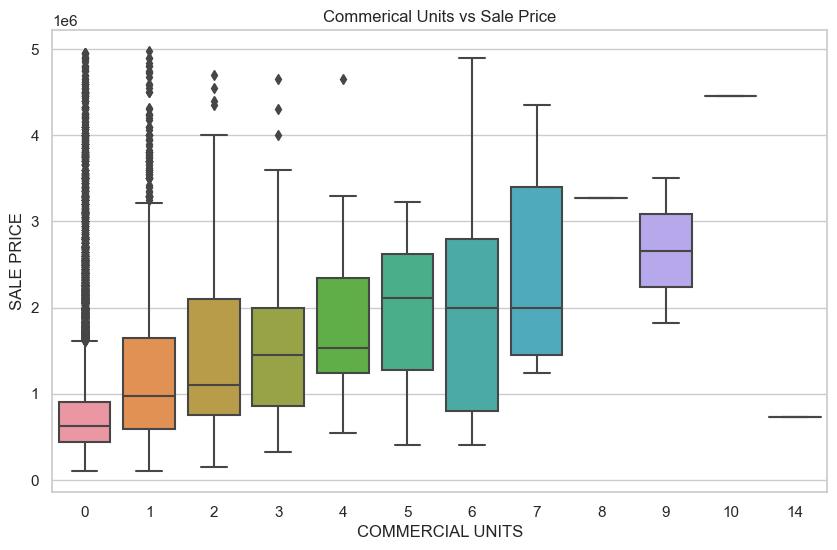

In [34]:
plt.figure(figsize=(10,6))
sns.boxplot(x='COMMERCIAL UNITS', y='SALE PRICE', data=data)
plt.title('Commerical Units vs Sale Price')
plt.show()

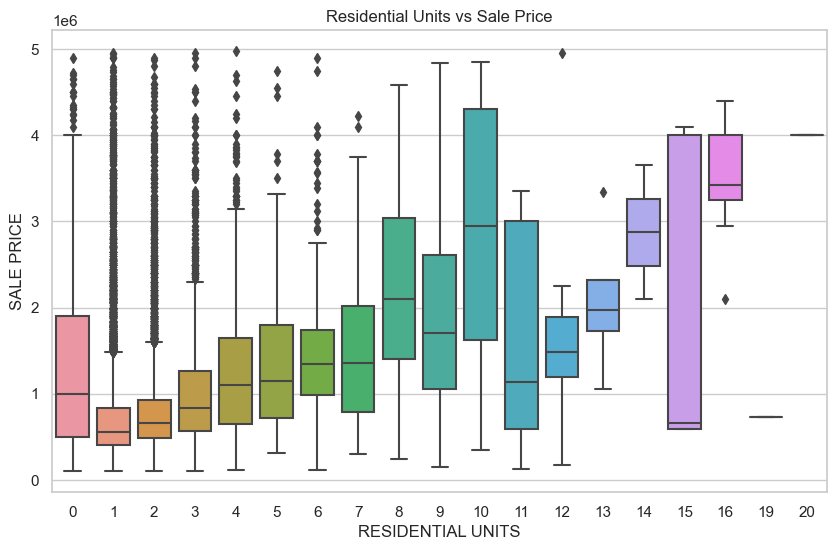

In [35]:
plt.figure(figsize=(10,6))
sns.boxplot(x='RESIDENTIAL UNITS', y='SALE PRICE', data=data)
plt.title('Residential Units vs Sale Price')
plt.show()

### Categorical Data Visualization

In [36]:
cat_data=data.select_dtypes(exclude=[np.number])
cat_data.describe()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
count,30400,30400,30400,30400,30400,30400,30400,30400,30400
unique,5,236,34,9,101,27503,1113,3,102
top,3,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,A1,429 KENT AVENUE,,1,A1
freq,11589,760,12215,23977,4573,156,26008,24512,4571


### Tax Class at Present

In [37]:
data['TAX CLASS AT PRESENT'].unique()

['2B', '2A', '4', '1', '2', '1A', '1B', '2C', '1C']
Categories (11, object): [' ', '1', '1A', '1B', ..., '2B', '2C', '3', '4']

In [38]:
pivot=data.pivot_table(index='TAX CLASS AT PRESENT', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
TAX CLASS AT PRESENT,
1,594000.0
1A,499500.0
1B,640606.5
1C,949334.0
2,865000.0
2A,1200000.0
2B,1847500.0
2C,810000.0
4,990000.0


<Axes: xlabel='TAX CLASS AT PRESENT'>

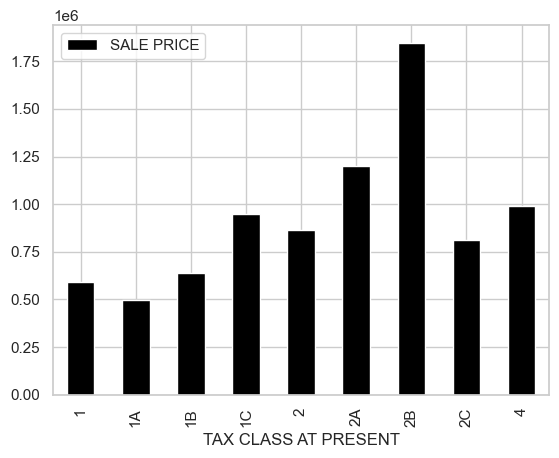

In [39]:
pivot.plot(kind='bar', color='black')

### Tax Class at Time of Sale

In [40]:
data['TAX CLASS AT TIME OF SALE'].unique()

[2, 4, 1]
Categories (4, int64): [1, 2, 3, 4]

In [41]:
pivot=data.pivot_table(index='TAX CLASS AT TIME OF SALE', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
TAX CLASS AT TIME OF SALE,
1,592000.0
2,925803.5
4,990000.0


<Axes: xlabel='TAX CLASS AT TIME OF SALE'>

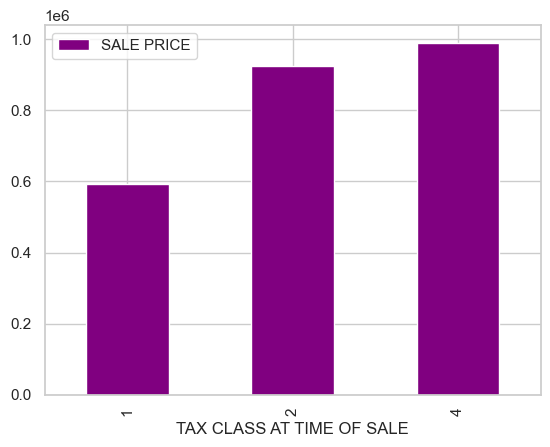

In [42]:
pivot.plot(kind='bar', color='purple')

### Borough

In [43]:
data['BOROUGH'].unique()

[1, 2, 3, 4, 5]
Categories (5, int64): [1, 2, 3, 4, 5]

In [44]:
pivot=data.pivot_table(index='BOROUGH', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
BOROUGH,
1,2250000.0
2,452750.0
3,860000.0
4,647000.0
5,486720.0


<Axes: xlabel='BOROUGH'>

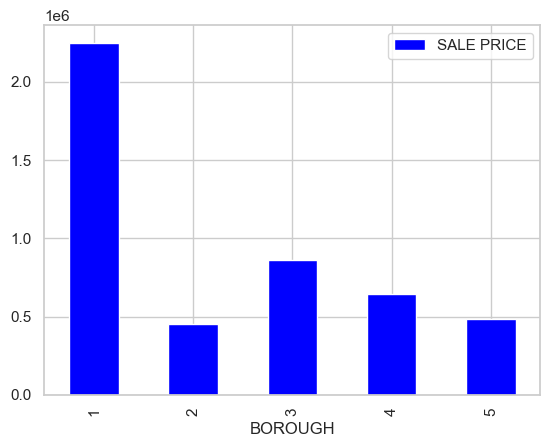

In [45]:
pivot.plot(kind='bar', color='blue')

#### It means max sale price is of BOROUGH==1 that is Manhattan.

### BUILDING CLASS CATEGORY



In [46]:
print(data['BUILDING CLASS CATEGORY'].nunique())

pivot=data.pivot_table(index='BUILDING CLASS CATEGORY', values='SALE PRICE', aggfunc=np.median)
pivot

34


,SALE PRICE
BUILDING CLASS CATEGORY,
01 ONE FAMILY DWELLINGS,510000.0
02 TWO FAMILY DWELLINGS,664075.5
03 THREE FAMILY DWELLINGS,820000.0
04 TAX CLASS 1 CONDOS,562518.5
05 TAX CLASS 1 VACANT LAND,720000.0
06 TAX CLASS 1 - OTHER,500000.0
07 RENTALS - WALKUP APARTMENTS,1280000.0
08 RENTALS - ELEVATOR APARTMENTS,3670000.0
11A CONDO-RENTALS,933423.5


<Axes: ylabel='BUILDING CLASS CATEGORY'>

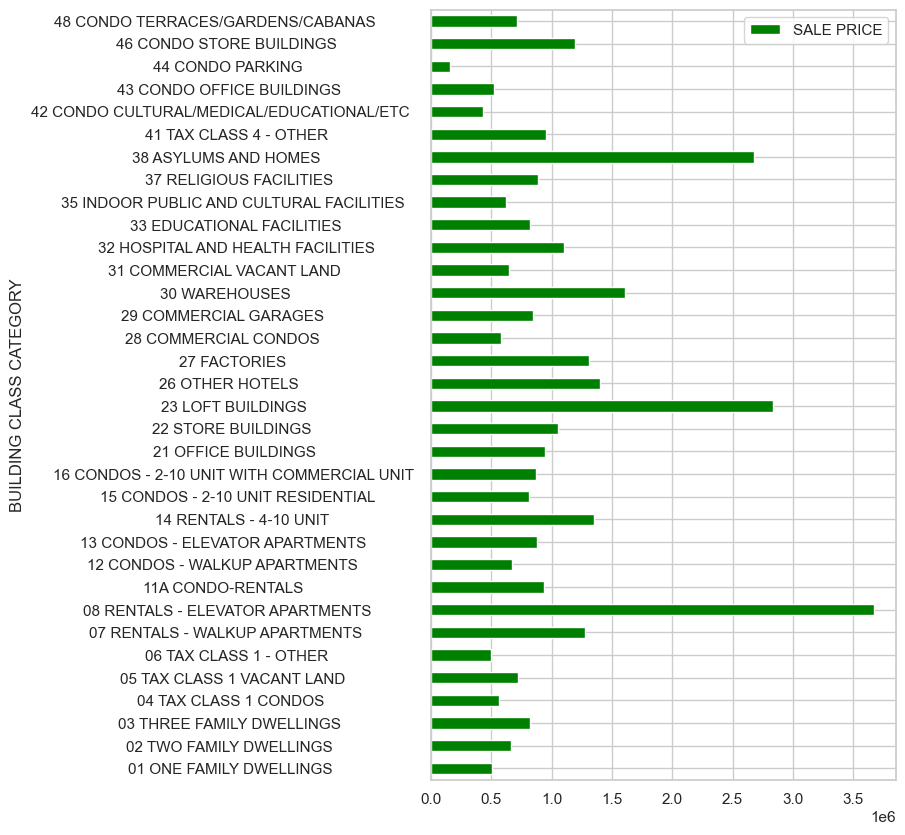

In [47]:
pivot.plot(kind='barh', color='green', figsize=(6, 10))

### Data Pre Processing

In [48]:
del data['ADDRESS']
del data['APARTMENT NUMBER']

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30400 entries, 3 to 84545
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BOROUGH                         30400 non-null  category
 1   NEIGHBORHOOD                    30400 non-null  object  
 2   BUILDING CLASS CATEGORY         30400 non-null  object  
 3   TAX CLASS AT PRESENT            30400 non-null  category
 4   BLOCK                           30400 non-null  int64   
 5   LOT                             30400 non-null  int64   
 6   BUILDING CLASS AT PRESENT       30400 non-null  object  
 7   ZIP CODE                        30400 non-null  int64   
 8   RESIDENTIAL UNITS               30400 non-null  int64   
 9   COMMERCIAL UNITS                30400 non-null  int64   
 10  TOTAL UNITS                     30400 non-null  int64   
 11  LAND SQUARE FEET                30400 non-null  float64 
 12  GROSS SQUARE FEET 

#### Normalising and Transforming Numerical columns



In [50]:
numeric_data.columns

Index(['BLOCK', 'LOT', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'SALE PRICE', 'LAMD SQIARE FEET'],
      dtype='object')

In [51]:
#Transform the numeric features using log(x+1)
from scipy.stats import skew
skewed = data[numeric_data.columns].apply(lambda x:skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
data[skewed] = np.log1p(data[skewed])

In [52]:
scaler = StandardScaler()
scaler.fit(data[numeric_data.columns])
scaler = scaler.transform(data[numeric_data.columns])

for i, col in enumerate(numeric_data.columns):
    data[col] = scaler[:,i]

In [53]:
data.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,LAMD SQIARE FEET
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,-2.117177,-0.637941,C4,-2.114612,4.352661,-0.229544,4.457323,0.340159,0.886232,0.090811,2,C4,2.836777,0.340159
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,-2.107772,-0.376056,C4,-2.114612,3.765250,-0.229544,3.842977,0.244994,0.706265,0.110598,2,C4,2.505938,0.244994
172,1,ALPHABET CITY,14 RENTALS - 4-10 UNIT,2A,-2.143530,-0.699500,S3,-2.114612,1.391465,3.321620,2.043488,0.193632,0.619349,0.082330,2,S3,2.558113,0.193632
174,1,ALPHABET CITY,14 RENTALS - 4-10 UNIT,2A,-2.136270,-1.477129,S5,-2.114612,2.578357,3.321620,3.073586,0.250985,0.657213,0.082330,2,S5,3.133774,0.250985
195,1,ALPHABET CITY,22 STORE BUILDINGS,4,-2.145962,-0.338052,K4,-2.114612,-2.666548,3.321620,-0.761703,0.112902,0.644022,0.051236,4,K4,2.738941,0.112902


In [54]:
#Dropping few columns
del data['BUILDING CLASS AT PRESENT']
del data['BUILDING CLASS AT TIME OF SALE']
del data['NEIGHBORHOOD']

#### One hot encoding categorical columns

In [55]:
#Select the variables to be one-hot encoded
one_hot_features = ['BOROUGH', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'TAX CLASS AT TIME OF SALE']

In [56]:
#Convert categorical variables into dummy/indicator variables (one-hot encoding)
one_hot_enconded = pd.get_dummies(data[one_hot_features])
one_hot_enconded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30400 entries, 3 to 84545
Data columns (total 54 columns):
 #   Column                                                                Non-Null Count  Dtype
---  ------                                                                --------------  -----
 0   BOROUGH_1                                                             30400 non-null  uint8
 1   BOROUGH_2                                                             30400 non-null  uint8
 2   BOROUGH_3                                                             30400 non-null  uint8
 3   BOROUGH_4                                                             30400 non-null  uint8
 4   BOROUGH_5                                                             30400 non-null  uint8
 5   BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS                       30400 non-null  uint8
 6   BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS                       30400 non-null  uint8
 7   BUILDING CLAS

In [57]:
#Replacing categorical columns with dummies
fdf = data.drop(one_hot_features, axis=1)
fdf = pd.concat([fdf, one_hot_enconded], axis=1)
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30400 entries, 3 to 84545
Data columns (total 65 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   BLOCK                                                                 30400 non-null  float64
 1   LOT                                                                   30400 non-null  float64
 2   ZIP CODE                                                              30400 non-null  float64
 3   RESIDENTIAL UNITS                                                     30400 non-null  float64
 4   COMMERCIAL UNITS                                                      30400 non-null  float64
 5   TOTAL UNITS                                                           30400 non-null  float64
 6   LAND SQUARE FEET                                                      30400 non-null  float64


### Train/Test Split

In [58]:
Y_fdf = fdf['SALE PRICE']
X_fdf = fdf.drop('SALE PRICE', axis=1)

X_fdf.shape, Y_fdf.shape

((30400, 64), (30400,))

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X_fdf, Y_fdf, test_size=0.3, random_state=34)

In [60]:
#Training set
X_train.shape, Y_train.shape

((21280, 64), (21280,))

In [61]:
#Testing set
X_test.shape, Y_test.shape

((9120, 64), (9120,))

### Modelling

In [62]:
#RMSE
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

#### Linear Regression


In [63]:
#Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
Y_pred_lin = linreg.predict(X_test)
rmse(Y_test, Y_pred_lin)

0.7748097610767669

In [67]:
linreg.coef_

array([-2.89341033e-01, -8.26345552e-03, -4.98044318e-02, -8.37533712e-02,
       -1.19976383e-02,  2.12156034e-01, -1.00714620e+12,  1.06135022e+00,
        8.25650058e-02,  1.00714620e+12,  4.08592014e+11,  4.08592014e+11,
        4.08592014e+11,  4.08592014e+11,  4.08592014e+11,  3.31296942e+11,
        3.31296942e+11,  3.31296942e+11,  6.18405304e+10,  3.31296942e+11,
        3.31296942e+11,  1.33059581e+11,  1.33059581e+11,  1.33059581e+11,
        1.33059581e+11,  1.33059581e+11,  1.33059581e+11,  1.33059581e+11,
        1.33059581e+11,  1.70200465e+10,  1.70200465e+10,  1.70200465e+10,
        1.70200465e+10,  1.70200465e+10,  1.70200465e+10,  1.70200465e+10,
        1.70200465e+10,  1.70200465e+10,  1.70200465e+10,  1.70200465e+10,
        1.70200465e+10,  1.70200465e+10,  1.70200465e+10,  1.70200465e+10,
        1.70200465e+10,  1.70200465e+10,  1.70200465e+10,  1.70200465e+10,
        1.70200465e+10, -5.43438725e+04, -3.24569472e+11, -5.51130595e+10,
       -3.24569472e+11, -

In [68]:
Y_pred = linreg.predict(X_test)

### Regression Evaluation Metrics

#### Comparing these metrics:

#### MAE is the easiest to understand, because it's the average error.
#### MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
#### RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
#### All of these are loss functions, because we want to minimize them.

In [69]:
MAE= metrics.mean_absolute_error(Y_test, Y_pred)
MSE=metrics.mean_squared_error(Y_test, Y_pred)
RMSE= np.sqrt(MSE)

In [70]:
MAE

0.5786191712168142

In [71]:
MSE

0.6003301658598366

In [72]:
RMSE

0.7748097610767669

#### Lasso Regression

In [64]:
#Lasso Regression
alpha = 0.00099
lasso_regr = Lasso(alpha=alpha, max_iter=50000)
lasso_regr.fit(X_train, Y_train)
Y_pred_lasso = lasso_regr.predict(X_test)
rmse(Y_test, Y_pred_lasso)

0.7855894275824266

#### Ridge Regression

In [65]:
#Ridge regression
ridge = Ridge(alpha=0.01)
ridge.fit(X_train, Y_train)
Y_pred_ridge = ridge.predict(X_test)
rmse(Y_test, Y_pred_ridge)

0.7737529809199201

#### Random Forest Regressor

In [66]:
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train, Y_train)
Y_pred_rf = rf_regr.predict(X_test)
rmse(Y_test, Y_pred_rf)

0.6119538225842175

In [73]:
test_residual= Y_test - Y_pred

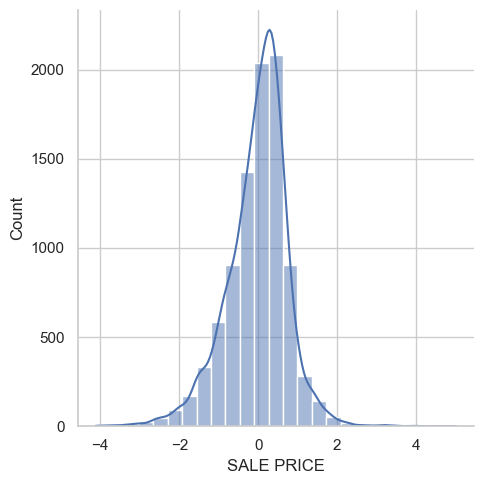

In [79]:
sns.displot(test_residual, bins=25, kde=True)

#### Residual plot shows residual error VS. true y value. 

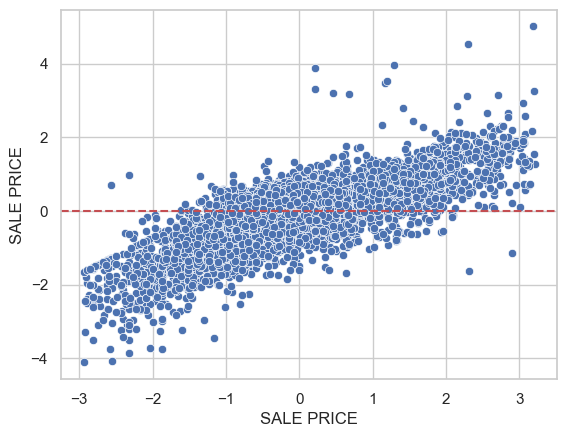

In [81]:
sns.scatterplot(x=Y_test, y=test_residual)

plt.axhline(y=0, color='r', ls='--')

#### Residual plot showing a clear pattern, indicating Linear Regression are valid.


### Conclusion

#### We can see that MAE works best for this dataset with RSME score of 0.5786.